## Read data from csv file

In [1]:
import csv
from unidecode import unidecode
latitude = []
longitude = []
city_name = []
county_name = []
with open('Datasets/ro.csv', newline='') as csvfile:
    DictReader = csv.DictReader(csvfile)
    ### Get latitude and longitude from csv
    for row in DictReader:
        city = unidecode(row['city'])
        city = city.replace("AY", 's')
        city = city.replace("APS", 't')
        city = city.replace("Af", 'a')
        city = city.replace("AC/", 'a')
        city_name = city_name + [city]
        county = unidecode(row['admin_name'])
        county = county.replace("AY", 's')
        county = county.replace("APS", 't')
        county = county.replace("Af", 'a')
        county = county.replace("AC/", 'a')
        county_name = county_name + [county]
        latitude = latitude + [row['lat']]
        longitude = longitude + [row['lng']]


## Set CUDA

In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Generate Graphs from data

Floresti,Cluj


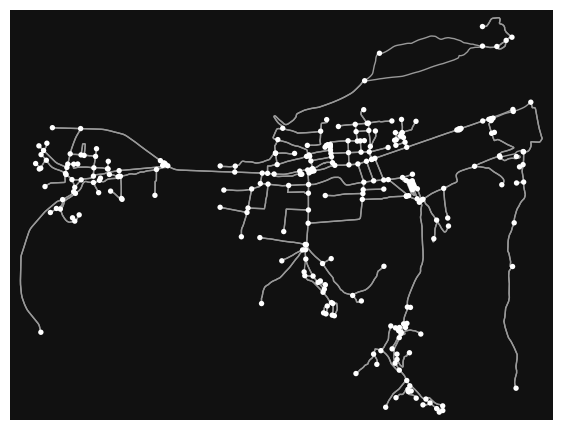

In [3]:
import networkx as nx
import geopandas as gpd
import osmnx as ox

location = city_name[40]+","+county_name[40]
print(location)

G = ox.graph_from_place(location, network_type="drive")

ox.save_graph_geopackage(G)
fig, ax = ox.plot_graph(G, figsize=(7,7))


## Hospital + street network

C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2625508967.py:9: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  hospitals = ox.geometries.geometries_from_place(location, tags={"amenity": "hospital", "amenity":"clinic"})


Number of hospitals  8
Number of streets  300


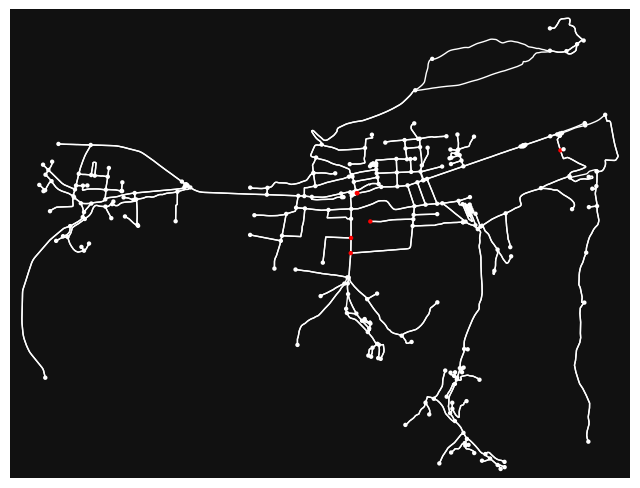

In [4]:
import networkx as nx
import geopandas as gpd
import osmnx as ox

# Get the street network graph
G = ox.graph_from_place(location, network_type="drive")

# Get the hospitals data
hospitals = ox.geometries.geometries_from_place(location, tags={"amenity": "hospital", "amenity":"clinic"})

# Create a new attribute for hospital nodes
for _, hospital in hospitals.iterrows():
    # Get the centroid of the hospital geometry
    centroid = hospital.geometry.centroid
    latitude, longitude = centroid.y, centroid.x
    
    # Find the nearest node in the street network graph to the hospital location
    nearest_node = ox.distance.nearest_nodes(G, longitude, latitude)
    
    # Add the hospital as a node to the graph
    G.add_node(nearest_node, type="hospital")

# Number of hospitals
print("Number of hospitals ", len(hospitals))
print("Number of streets ",  len(G))

# Set node colors based on their type
node_colors = ["red" if "type" in G.nodes[node] and G.nodes[node]["type"] == "hospital" else "white" for node in G.nodes()]
# Plot the graph with hospitals colored red and the rest with white
fig, ax = ox.plot_graph(G, node_color=node_colors, node_size=10, edge_color='w')


## Get average distance between hospitals and streets

In [5]:
import networkx as nx
import osmnx as ox
import numpy as np
import random
from functools import lru_cache

# Get the street network graph
G = ox.graph_from_place(location, network_type="drive")

# Get the hospitals data
hospitals = ox.features.features_from_place(location, tags={"amenity": "hospital", "amenity": "clinic"})

# Identify hospital nodes
hospital_nodes = []
for _, hospital in hospitals.iterrows():
    centroid = hospital.geometry.centroid
    latitude, longitude = centroid.y, centroid.x
    nearest_node = ox.distance.nearest_nodes(G, longitude, latitude)
    hospital_nodes.append(nearest_node)

# Get a list of all street nodes (excluding hospital nodes)
street_nodes = [node for node in G.nodes() if node not in hospital_nodes]

# Randomly sample 200 street nodes
sampled_street_nodes = random.sample(street_nodes, 250)

# Caching mechanism for ox.shortest_path results
@lru_cache(maxsize=None)
def get_shortest_path_length(source, target):
    path = ox.shortest_path(G, source, target, weight='length')
    if path is None or len(path) <= 1:
        return float('inf')
    return sum(ox.utils_graph.get_route_edge_attributes(G, path, 'length'))

# Calculate the shortest path lengths from each sampled street node to the closest hospital node
shortest_path_lengths = []
for street_node in sampled_street_nodes:
    min_path_length = float('inf')
    for hospital_node in hospital_nodes:
        try:
            path_length = get_shortest_path_length(hospital_node, street_node)
            if path_length < min_path_length:
                min_path_length = path_length
        except (nx.NetworkXNoPath, KeyError):
            pass  # If there is no path or other errors, we skip this pair
    if min_path_length < float('inf'):
        shortest_path_lengths.append(min_path_length)

# Calculate the average shortest path length - METERS
if shortest_path_lengths:
    average_shortest_path_length = np.mean(shortest_path_lengths)
    print(f"Average shortest path length from 250 random street nodes to the closest hospital: {average_shortest_path_length}")
else:
    print("No valid shortest paths found.")


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2998165993.py:33: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return sum(ox.utils_graph.get_route_edge_attributes(G, path, 'length'))


Average shortest path length from 250 random street nodes to the closest hospital: 2505.111992


## Get average time between hospitals and streets

In [6]:
import random
import networkx as nx
import osmnx as ox
import numpy as np



# Define typical speeds (in km/h) for different street types
street_speeds = {
    'motorway': 90,
    'trunk': 70,
    'primary': 50,
    'secondary': 45,
    'tertiary': 35,
    'residential': 25,
    'unclassified': 20,
    'service': 10
}

for i in range(1, len(city_name)):
    try:
        if i != 0:
            location = city_name[i]+","+county_name[i]
        else:
            location = city_name[i]
            
        # Define the location and graph
            
        G = ox.graph_from_place(location, network_type="drive")

        # Get the hospitals data
        hospitals = ox.features.features_from_place(location, tags={"amenity": "hospital", "amenity":"clinic", "healthcare":"hospital", "emergency":"yes"})

        # Extract hospital nodes
        hospital_nodes = []
        for _, hospital in hospitals.iterrows():
            point = hospital.geometry.centroid
            nearest_node = ox.distance.nearest_nodes(G, point.x, point.y)
            hospital_nodes.append(nearest_node)
        hospital_nodes = list(set(hospital_nodes))

        # Ensure travel_time is calculated for each edge
        default_speed_kph = 25
        for u, v, k, data in G.edges(data=True, keys=True):
            highway = data.get('highway')
            if isinstance(highway, list):
                highway = highway[0]  # If highway type is a list, take the first element
            speed_kph = street_speeds.get(highway, default_speed_kph)
            if 'length' in data:
                length_km = data['length'] / 1000  # Convert length to kilometers
                travel_time_hours = length_km / speed_kph  # Travel time in hours
                travel_time_seconds = travel_time_hours * 3600  # Convert to seconds
                # Introduce random delay to simulate real-world conditions
                random_delay = np.random.uniform(15, 30)  # Random delay between 5 and 15 seconds
                data['travel_time'] = travel_time_seconds + random_delay

        # Extract street nodes
        street_nodes = list(G.nodes)
        sampled_street_nodes = random.sample(street_nodes, 200)

        # Compute shortest paths for each street node to the closest hospital node
        shortest_travel_times = []
        for street_node in sampled_street_nodes:
            min_travel_time = float('inf')
            for hospital_node in hospital_nodes:
                try:
                    travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))
                    if travel_time < min_travel_time:
                        min_travel_time = travel_time
                except Exception as e:
                    continue
            if min_travel_time < float('inf'):
                shortest_travel_times.append(min_travel_time)

        # Calculate the average travel time
        if shortest_travel_times:
            average_travel_time = sum(shortest_travel_times) / len(shortest_travel_times)
            travel_time_minutes = (int)(average_travel_time/60)
            travel_time_seconds = average_travel_time%60
            print(f"{location} - Number of hospitals/clinics: {len(hospital)}")
            print(f"{location} - Average shortest travel time from 200 streets to the closest hospital: {travel_time_minutes} minutes {travel_time_seconds:.1f} seconds")
        else:
            print("No valid shortest travel times found.")
    except Exception as e:
        print(f"Error processing {location}: {e}")


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Cluj-Napoca,Cluj - Number of hospitals/clinics: 48
Cluj-Napoca,Cluj - Average shortest travel time from 200 streets to the closest hospital: 6 minutes 17.2 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Iasi,Iasi - Number of hospitals/clinics: 35
Iasi,Iasi - Average shortest travel time from 200 streets to the closest hospital: 8 minutes 18.2 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Constanta,Constanta - Number of hospitals/clinics: 43
Constanta,Constanta - Average shortest travel time from 200 streets to the closest hospital: 4 minutes 1.0 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Timisoara,Timis - Number of hospitals/clinics: 51
Timisoara,Timis - Average shortest travel time from 200 streets to the closest hospital: 4 minutes 47.7 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Brasov,Brasov - Number of hospitals/clinics: 33
Brasov,Brasov - Average shortest travel time from 200 streets to the closest hospital: 8 minutes 40.7 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Craiova,Dolj - Number of hospitals/clinics: 30
Craiova,Dolj - Average shortest travel time from 200 streets to the closest hospital: 7 minutes 21.1 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Galati,Galati - Number of hospitals/clinics: 35
Galati,Galati - Average shortest travel time from 200 streets to the closest hospital: 5 minutes 16.9 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Oradea,Bihor - Number of hospitals/clinics: 18
Oradea,Bihor - Average shortest travel time from 200 streets to the closest hospital: 10 minutes 48.3 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Ploiesti,Prahova - Number of hospitals/clinics: 38
Ploiesti,Prahova - Average shortest travel time from 200 streets to the closest hospital: 4 minutes 51.3 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Braila,Braila - Number of hospitals/clinics: 21
Braila,Braila - Average shortest travel time from 200 streets to the closest hospital: 6 minutes 58.3 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Arad,Arad - Number of hospitals/clinics: 24
Arad,Arad - Average shortest travel time from 200 streets to the closest hospital: 8 minutes 21.7 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Pitesti,Arges - Number of hospitals/clinics: 24
Pitesti,Arges - Average shortest travel time from 200 streets to the closest hospital: 8 minutes 2.3 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Bacau,Bacau - Number of hospitals/clinics: 18
Bacau,Bacau - Average shortest travel time from 200 streets to the closest hospital: 10 minutes 36.0 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Sibiu,Sibiu - Number of hospitals/clinics: 59
Sibiu,Sibiu - Average shortest travel time from 200 streets to the closest hospital: 6 minutes 51.6 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Targu-Mures,Mures - Number of hospitals/clinics: 39
Targu-Mures,Mures - Average shortest travel time from 200 streets to the closest hospital: 4 minutes 23.6 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Baia Mare,Maramures - Number of hospitals/clinics: 17
Baia Mare,Maramures - Average shortest travel time from 200 streets to the closest hospital: 13 minutes 11.1 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Buzau,Buzau - Number of hospitals/clinics: 25
Buzau,Buzau - Average shortest travel time from 200 streets to the closest hospital: 5 minutes 14.4 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Ramnicu Valcea,Valcea - Number of hospitals/clinics: 17
Ramnicu Valcea,Valcea - Average shortest travel time from 200 streets to the closest hospital: 9 minutes 54.8 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Satu Mare,Satu Mare - Number of hospitals/clinics: 20
Satu Mare,Satu Mare - Average shortest travel time from 200 streets to the closest hospital: 8 minutes 55.8 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Botosani,Botosani - Number of hospitals/clinics: 23
Botosani,Botosani - Average shortest travel time from 200 streets to the closest hospital: 7 minutes 6.9 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Suceava,Suceava - Number of hospitals/clinics: 14
Suceava,Suceava - Average shortest travel time from 200 streets to the closest hospital: 13 minutes 32.4 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Resita,Caras-Severin - Number of hospitals/clinics: 12
Resita,Caras-Severin - Average shortest travel time from 200 streets to the closest hospital: 8 minutes 50.0 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Drobeta-Turnu Severin,Mehedinti - Number of hospitals/clinics: 16
Drobeta-Turnu Severin,Mehedinti - Average shortest travel time from 200 streets to the closest hospital: 6 minutes 26.5 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Piatra Neamt,Neamt - Number of hospitals/clinics: 18
Piatra Neamt,Neamt - Average shortest travel time from 200 streets to the closest hospital: 6 minutes 23.7 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Bistrita,Bistrita-Nasaud - Number of hospitals/clinics: 8
Bistrita,Bistrita-Nasaud - Average shortest travel time from 200 streets to the closest hospital: 13 minutes 58.2 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Targu Jiu,Gorj - Number of hospitals/clinics: 14
Targu Jiu,Gorj - Average shortest travel time from 200 streets to the closest hospital: 11 minutes 3.6 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Targoviste,Dambovita - Number of hospitals/clinics: 17
Targoviste,Dambovita - Average shortest travel time from 200 streets to the closest hospital: 6 minutes 59.9 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Focsani,Vrancea - Number of hospitals/clinics: 22
Focsani,Vrancea - Average shortest travel time from 200 streets to the closest hospital: 6 minutes 50.9 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Tulcea,Tulcea - Number of hospitals/clinics: 12
Tulcea,Tulcea - Average shortest travel time from 200 streets to the closest hospital: 10 minutes 20.4 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Alba Iulia,Alba - Number of hospitals/clinics: 13
Alba Iulia,Alba - Average shortest travel time from 200 streets to the closest hospital: 11 minutes 40.3 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Slatina,Olt - Number of hospitals/clinics: 27
Slatina,Olt - Average shortest travel time from 200 streets to the closest hospital: 5 minutes 21.1 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Vaslui,Vaslui - Number of hospitals/clinics: 13
Vaslui,Vaslui - Average shortest travel time from 200 streets to the closest hospital: 5 minutes 30.1 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Calarasi,Calarasi - Number of hospitals/clinics: 13
Calarasi,Calarasi - Average shortest travel time from 200 streets to the closest hospital: 7 minutes 1.8 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Giurgiu,Giurgiu - Number of hospitals/clinics: 9
Giurgiu,Giurgiu - Average shortest travel time from 200 streets to the closest hospital: 7 minutes 22.6 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Popesti-Leordeni,Ilfov - Number of hospitals/clinics: 9
Popesti-Leordeni,Ilfov - Average shortest travel time from 200 streets to the closest hospital: 8 minutes 27.4 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Deva,Hunedoara - Number of hospitals/clinics: 19
Deva,Hunedoara - Average shortest travel time from 200 streets to the closest hospital: 7 minutes 17.0 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Barlad,Vaslui - Number of hospitals/clinics: 9
Barlad,Vaslui - Average shortest travel time from 200 streets to the closest hospital: 5 minutes 48.5 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Zalau,Salaj - Number of hospitals/clinics: 13
Zalau,Salaj - Average shortest travel time from 200 streets to the closest hospital: 11 minutes 1.8 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Hunedoara,Hunedoara - Number of hospitals/clinics: 10
Hunedoara,Hunedoara - Average shortest travel time from 200 streets to the closest hospital: 12 minutes 44.4 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Floresti,Cluj - Number of hospitals/clinics: 17
Floresti,Cluj - Average shortest travel time from 200 streets to the closest hospital: 8 minutes 2.2 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Sfantu-Gheorghe,Covasna - Number of hospitals/clinics: 19
Sfantu-Gheorghe,Covasna - Average shortest travel time from 200 streets to the closest hospital: 6 minutes 50.7 seconds
Error processing Roman,Neamt: No data elements in server response. Check log and query location/tags.
Error processing Voluntari,Bucuresti: Found no graph nodes within the requested polygon


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Turda,Cluj - Number of hospitals/clinics: 18
Turda,Cluj - Average shortest travel time from 200 streets to the closest hospital: 6 minutes 12.4 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Miercurea-Ciuc,Harghita - Number of hospitals/clinics: 33
Miercurea-Ciuc,Harghita - Average shortest travel time from 200 streets to the closest hospital: 9 minutes 37.9 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Slobozia,Ialomita - Number of hospitals/clinics: 7
Slobozia,Ialomita - Average shortest travel time from 200 streets to the closest hospital: 8 minutes 6.0 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Alexandria,Teleorman - Number of hospitals/clinics: 13
Alexandria,Teleorman - Average shortest travel time from 200 streets to the closest hospital: 5 minutes 37.6 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Bragadiru,Ilfov - Number of hospitals/clinics: 5
Bragadiru,Ilfov - Average shortest travel time from 200 streets to the closest hospital: 15 minutes 53.1 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Medias,Sibiu - Number of hospitals/clinics: 10
Medias,Sibiu - Average shortest travel time from 200 streets to the closest hospital: 9 minutes 55.8 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Lugoj,Timis - Number of hospitals/clinics: 11
Lugoj,Timis - Average shortest travel time from 200 streets to the closest hospital: 10 minutes 19.1 seconds
Error processing Medgidia,Constanta: No data elements in server response. Check log and query location/tags.


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Navodari,Constanta - Number of hospitals/clinics: 6
Navodari,Constanta - Average shortest travel time from 200 streets to the closest hospital: 18 minutes 42.4 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Onesti,Bacau - Number of hospitals/clinics: 19
Onesti,Bacau - Average shortest travel time from 200 streets to the closest hospital: 7 minutes 10.2 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Pantelimon,Ilfov - Number of hospitals/clinics: 13
Pantelimon,Ilfov - Average shortest travel time from 200 streets to the closest hospital: 8 minutes 12.7 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Tecuci,Galati - Number of hospitals/clinics: 18
Tecuci,Galati - Average shortest travel time from 200 streets to the closest hospital: 7 minutes 14.9 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Sighetu Marmatiei,Maramures - Number of hospitals/clinics: 18
Sighetu Marmatiei,Maramures - Average shortest travel time from 200 streets to the closest hospital: 9 minutes 24.4 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Mangalia,Constanta - Number of hospitals/clinics: 21
Mangalia,Constanta - Average shortest travel time from 200 streets to the closest hospital: 5 minutes 20.3 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Dej,Cluj - Number of hospitals/clinics: 4
Dej,Cluj - Average shortest travel time from 200 streets to the closest hospital: 10 minutes 57.4 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Odorheiu Secuiesc,Harghita - Number of hospitals/clinics: 13
Odorheiu Secuiesc,Harghita - Average shortest travel time from 200 streets to the closest hospital: 9 minutes 5.9 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Petrosani,Hunedoara - Number of hospitals/clinics: 20
Petrosani,Hunedoara - Average shortest travel time from 200 streets to the closest hospital: 9 minutes 28.0 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Sacele,Brasov - Number of hospitals/clinics: 9
Sacele,Brasov - Average shortest travel time from 200 streets to the closest hospital: 18 minutes 51.3 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Pascani,Iasi - Number of hospitals/clinics: 9
Pascani,Iasi - Average shortest travel time from 200 streets to the closest hospital: 12 minutes 54.3 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Ramnicu Sarat,Buzau - Number of hospitals/clinics: 10
Ramnicu Sarat,Buzau - Average shortest travel time from 200 streets to the closest hospital: 6 minutes 24.9 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Reghin,Mures - Number of hospitals/clinics: 23
Reghin,Mures - Average shortest travel time from 200 streets to the closest hospital: 6 minutes 59.0 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Mioveni,Arges - Number of hospitals/clinics: 11
Mioveni,Arges - Average shortest travel time from 200 streets to the closest hospital: 11 minutes 20.1 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Campina,Prahova - Number of hospitals/clinics: 18
Campina,Prahova - Average shortest travel time from 200 streets to the closest hospital: 7 minutes 37.3 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Borsa,Maramures - Number of hospitals/clinics: 9
Borsa,Maramures - Average shortest travel time from 200 streets to the closest hospital: 14 minutes 57.3 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Campulung,Arges - Number of hospitals/clinics: 17
Campulung,Arges - Average shortest travel time from 200 streets to the closest hospital: 7 minutes 26.0 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Fetesti,Ialomita - Number of hospitals/clinics: 7
Fetesti,Ialomita - Average shortest travel time from 200 streets to the closest hospital: 11 minutes 20.4 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Caracal,Olt - Number of hospitals/clinics: 14
Caracal,Olt - Average shortest travel time from 200 streets to the closest hospital: 5 minutes 22.0 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Sebes,Alba - Number of hospitals/clinics: 18
Sebes,Alba - Average shortest travel time from 200 streets to the closest hospital: 8 minutes 53.4 seconds


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12392\2852978624.py:67: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, ox.shortest_path(G, street_node, hospital_node, weight='travel_time'), 'travel_time'))


Fagaras,Brasov - Number of hospitals/clinics: 13
Fagaras,Brasov - Average shortest travel time from 200 streets to the closest hospital: 4 minutes 57.5 seconds
